# C2F Module Guide

This notebook is here to introduce you the basic usage of this package.

For demonstration purposes, we'll start off with the usage of a pretrained model. How you can train the model on your own, you will see after that.

## 1. Pretrained Model Usage

Let's see how we can load a fully pretrained model and use it to colorize black & white images.

### 1.1. Load a fully trained "base" or "c2f" model

Since the `main.py` file is configured with an argument parser, you also have to pass arguments as such to it. Below you see an example that loads a pretrained "c2f" model from the checkpoint path `./lightning_logs/c2f/checkpoints/last.ckpt`.

*Note:* Possible `--model` arguments are `base` or `c2f`

For more information please consider typing `python3 main.py --help` in the console.

In [1]:
from pytorch_lightning.utilities.model_summary import summarize
from main import main

# Define args since `main.py` is configured with an argument parser
args = ("--model c2f "
        "--full_ckpt_path ./logs/c2f/checkpoints/last.ckpt "
        ).split()

# Get fully trained model and print summary
model = main(args)
summarize(model)

Model <class 'fastai.vision.models.unet.DynamicUnet'> initialized with norm initialization
Model <class 'src.discriminator.PatchDiscriminator'> initialized with norm initialization


  | Name  | Type               | Params
---------------------------------------------
0 | G_net | DynamicUnet        | 31.1 M
1 | D_net | PatchDiscriminator | 2.8 M 
---------------------------------------------
33.9 M    Trainable params
0         Non-trainable params
33.9 M    Total params
135.515   Total estimated model params size (MB)

### 1.2. Colorize

In order to colorize images we of course need some images. So let's load some exemplary images!

/Users/tstreule/PycharmProjects/eth/dl21_project/src/utils/image.py:283: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


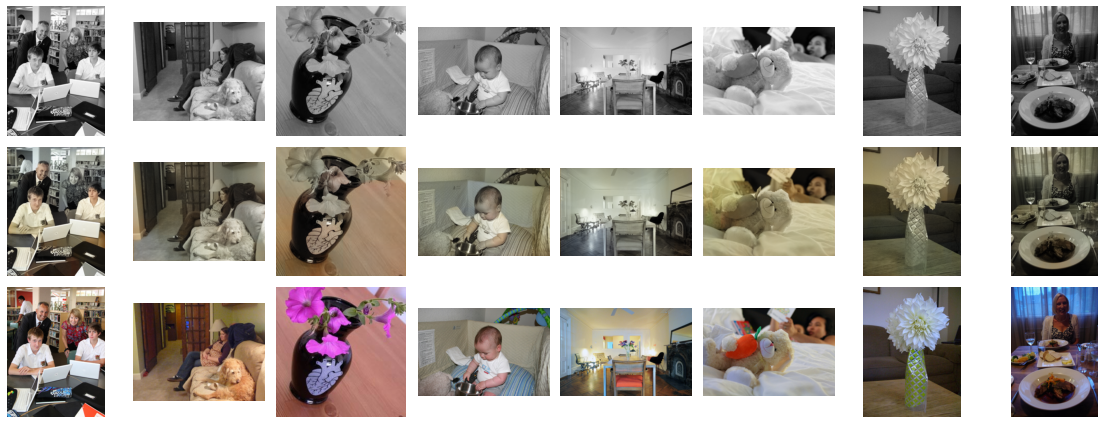

In [2]:
# from src.gan import predict_and_visualize
from src.utils.data import make_dataloader

# Get exemplary image batch
data_dir = "https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz"  # web link or path to directory
# For speed-up, we limit the image size to maximally `max_img_size` pixels
dataloader = make_dataloader(data_dir, max_img_size=256)
batch = next(iter(dataloader))

# Predict and visualize image batch
preds = model.colorize(batch)
model.visualize(preds, batch, show=True, save=False)

Note that the last row contains the original images. The first and second row depict the black & white and colorized images, respectively.

## 2. Training

Now, let's have a look on how to train a model.

### 2.1. Generator pretraining

Since we are training a GAN it is not a bad practise to pre-train the generator. We do this quite similarly as loading a fully trained model.

In [3]:
# For demonstration purposes, we pass the following arguments
demo_args = ("--batch_size 4 --dataset_size 32 --max_img_size 64 "
             "--log_every_n_steps 5 --max_epochs 3 ").split()

# Define arguments
# More options are available, cf. `python main.py --model pretrain --help`
pretrain_args = demo_args + "--model pretrain ".split()

# Case 1: Pretrain base model
pretrain_base_model = main(pretrain_args)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type        | Params
--------------------------------------
0 | G_net | DynamicUnet | 31.1 M
--------------------------------------
31.1 M    Trainable params
0         Non-trainable params
31.1 M    Total params
124.399   Total estimated model params size (MB)


Model <class 'fastai.vision.models.unet.DynamicUnet'> initialized with norm initialization


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [4]:
# Case 2: Pretrain c2f model
pretrain_args += "--gen_net_params 3 2 128 ".split()
pretrain_c2f_model = main(pretrain_args)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type        | Params
--------------------------------------
0 | G_net | DynamicUnet | 31.1 M
--------------------------------------
31.1 M    Trainable params
0         Non-trainable params
31.1 M    Total params
124.452   Total estimated model params size (MB)


Model <class 'fastai.vision.models.unet.DynamicUnet'> initialized with norm initialization


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

That's all you need to do. Easy, right?

It is worth mentioning that you can significantly speed up the training by passing the argument `--gpus -1`. However, your computer must have one or more NVIDIA GPUs!

### 2.2. GAN Training

For the following steps, it is assumed that a "pretrain" model checkpoint exists (most likely you can find it in a `./lightnings_logs` folder). You need to pass its path as a `--pretrained_ckpt_path` argument.

In [5]:
# Case 1: Base model
# More options are available, cf. `python main.py --model base --help`
base_args = demo_args + "--model base ".split()
base_args += "--pretrained_ckpt_path ./lightning_logs/version_0/checkpoints/last.ckpt ".split()
base_model = main(base_args)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type               | Params
---------------------------------------------
0 | G_net | DynamicUnet        | 31.1 M
1 | D_net | PatchDiscriminator | 2.8 M 
---------------------------------------------
33.9 M    Trainable params
0         Non-trainable params
33.9 M    Total params
135.461   Total estimated model params size (MB)


Model <class 'fastai.vision.models.unet.DynamicUnet'> initialized with norm initialization
Model <class 'src.discriminator.PatchDiscriminator'> initialized with norm initialization


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [6]:
# Case 2: C2F model
# More options are available, cf. `python main.py --model c2f --help`
c2f_args = demo_args + "--model c2f --gen_net_params 3 2 128 ".split()
c2f_args += "--pretrained_ckpt_path ./lightning_logs/version_1/checkpoints/last.ckpt ".split()
c2f_model = main(c2f_args)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type               | Params
---------------------------------------------
0 | G_net | DynamicUnet        | 31.1 M
1 | D_net | PatchDiscriminator | 2.8 M 
---------------------------------------------
33.9 M    Trainable params
0         Non-trainable params
33.9 M    Total params
135.515   Total estimated model params size (MB)


Model <class 'fastai.vision.models.unet.DynamicUnet'> initialized with norm initialization
Model <class 'src.discriminator.PatchDiscriminator'> initialized with norm initialization


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## 3. TensorBoard

Logging with TensorBoard comes on the hood. While or after training you can open TensorBoard in the browser with the command `tensorboard --logdir ./lightning_logs`.
